# Keras Autoencoder with Annoy for CBIR

## Edge Detection 64x128 pixels, 8x16x128 encoder convolutions, GlobalAverage to 128 dimensions

### Results: It _appears_ that this isn't as effective as just a regular grayscale run, even though it allows the network to focus on the speckles only, instead of the curve of the pill itself. Don't know...  However, issue is that knn and annoy have pills with rotations that a closer to 'unmatched' pills that their other rotated images.

### Things to try
KL Divergence loss instead of cross entropy
Create a loss that minimizes the difference in GlobalMaxPool vector in images that are simply rotated
    i.e., Image 219 and 201-45 should have the same output vector.
What if the GlobalPool vector IS the embedding and we train on rotated images as input but always 
    the same unrotated image as predicted vector
Alternatively to above, train a decent autoencoder without a GlobalPool (as currently), then add
    a GlobalPool vector and retrain without the decoder, using the 1D encoding for a single pill rotation
    as the target output, and other rotations (of the same pill) as the input. In theory, the pill selected
    for the target output could change each epoch.
    IDEA: would it be easy to generate a batch (of whatever size) where the entire batch was a single pill
        through many different rotations?  (Batch of 16 would be the same pill image rotated 16 times.)

In [58]:
import keras
keras.__version__

'2.2.2'

In [59]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7046320820492389737
]


In [60]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]

In [61]:
from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

# Train model

## Training variables

In [151]:

#target_image_size = (64,112)
#target_image_size = (32,64)
target_image_size = (64,128)
#target_image_size = (48,96)

color_mode='grayscale' # 'grayscale' or 'rgb'

if color_mode=='grayscale':
    target_image_size_3D = (target_image_size[0], target_image_size[1], 1)
else: #then rgb
    target_image_size_3D = (target_image_size[0], target_image_size[1], 3)

batch_size_training = 32
batch_size_validation = 32

# Directories
image_dir_base = 'data_bw_edge_with_rotations'
image_dir_training = image_dir_base + '/train'
image_dir_validation = image_dir_base + '/validate'
image_dir_testing = image_dir_base + '/test'
image_dir_samples = image_dir_testing

# Training variables
training_steps_per_epoch = 200
training_number_of_epoch = 100
validation_steps = 200
training_early_stop_patience = 4

# Model name to save
model_name='autoencoder_edge'

# Model name to load for Testing
model_name_pretrained = model_name

# Encoder model name
model_name_encoder = model_name + '-encoder'

In [152]:
# Testing variables

In [153]:
# Import required items for training
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import callbacks
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


from sklearn.metrics import label_ranking_average_precision_score
import time

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## Convenience functions

In [154]:
# Unfortunately, matplotlib, cv2, etc only print in greyscale 
#   when you have 3 color axes (RGB) all set to make the image look grey.
#   But Keras loads greyscale images with only a single number (to optimize training, etc)
#   So, we need to convert any Keras greyscale images to have 3 values

def display_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        plt.imshow(single_image)
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        plt.imshow(si)
        
def get_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        return single_image
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        return si
    

## ImageDataGenerators 

In [155]:
# Created the Train and Validation image generators

# Load the data (in that case MNIST)
train_datagen = ImageDataGenerator(
        #shear_range=0.05,
        #zoom_range=0.01,
        #rotation_range=5.00,
        #height_shift_range=0.10,
        #width_shift_range=0.10,
        rescale=1. / 255,
        horizontal_flip=False)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        image_dir_training,
        target_size=target_image_size,
        batch_size=batch_size_training,
        class_mode='input',
        color_mode=color_mode)

validation_generator = validation_datagen.flow_from_directory(
        image_dir_validation,
        target_size=target_image_size,
        batch_size=batch_size_validation,
        class_mode='input',
        color_mode=color_mode)



Found 722 images belonging to 1 classes.
Found 191 images belonging to 1 classes.


Found 96 images belonging to 1 classes.


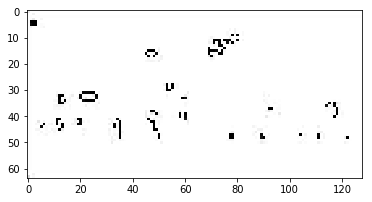

In [156]:
# Create an Sample image generator and get sample images to use throughout all the training for visualization


# Create callback function to use later.
sample_datagen = ImageDataGenerator(rescale=1. / 255)

sample_generator = sample_datagen.flow_from_directory(
        image_dir_samples,
        target_size=target_image_size,
        batch_size=16,
        class_mode='input',
        color_mode=color_mode)

next_batch = next(sample_generator)
sample_images = next_batch[0]
test_image=sample_images[1]
ti = test_image

#
display_image(test_image)


## Define Model for Training - Architecture

In [157]:
def define_model():
    
    big_conv = (7,7)
    num_conv = 128
    
    
    #Input
    input_img = Input(shape=target_image_size_3D, name='input')  # adapt this if using `channels_first` image data format
    
     # Layer 10
    x = Conv2D(16, (5, 5), activation='relu', padding='same', strides=(1,1))(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(1,1))(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
#    # Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
#    
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)

    # Layer 30

#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((4, 4), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    # Uplayer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((4, 4))(x)
    
    # Uplayer 30
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)


#    #Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
#    
#    x = Conv2D(32, (3, 3), activation='relu')(x)
#    #x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
    
    # Uplayer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 10
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Output
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoded')(x)


    autoencoder = Model(input_img, outputs=decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    print(autoencoder.outputs)
        
    return autoencoder
    

In [158]:
# Create callback to write sample images to disk
class ProgressCallback(callbacks.Callback):
    
    def __init__(self, sample_image):
        self.sample_image = sample_image
        self.image4d = self.sample_image[None,:] # predict needs a batch of images (shape=4). This adds a dimension  
        
    def on_epoch_end(self, epoch, logs={}):
        
        processed_images = self.model.predict(x=[self.image4d],batch_size=1)
         
        # plot the image and save it
        f = plt.figure()
        f.add_subplot(1, 2, 1)  # this line outputs images side-by-side
        sim = get_image(self.sample_image)
        plt.imshow(sim)
        f.add_subplot(1, 2, 2)  # this line outputs images side-by-side
        pim = get_image(processed_images[0])
        plt.imshow(pim)
        plt.suptitle('Epoch ' + str(epoch))
        filename = 'epoch-' + str(epoch) + '.png'
        plt.savefig(filename)
        plt.close()
        #plt.show()


In [159]:
# Train the model
def train_model(model_to_train):
    progress = ProgressCallback(sample_image=sample_images[0])
    early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=training_early_stop_patience,
                              verbose=0, mode='auto')
    model_to_train.fit_generator(
        train_generator,
        steps_per_epoch=training_steps_per_epoch,
        epochs=training_number_of_epoch,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False),progress,early_stop])
    
    model_to_train.save(model_name + '.h5')
    
    return model_to_train

In [160]:
#autoencoder.save('autoencoder_8by14by128.h5')

In [161]:
# Train the model
x = define_model()

[<tf.Tensor 'decoded_7/Sigmoid:0' shape=(?, 64, 128, 1) dtype=float32>]


In [163]:
print(x.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 128, 1)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 64, 128, 16)       416       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 64, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 32, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 16, 32, 128)       36992     
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 8, 128)         0         
__________

In [164]:
# Show encoder output size (before global pooling)
e = x.get_layer('encoder')
e.output

<tf.Tensor 'encoder_7/MaxPool:0' shape=(?, 4, 8, 128) dtype=float32>

In [165]:
autoencoder = x
autoencoder = train_model(autoencoder)

Epoch 1/100
200/200 [==============================] - 88s 442ms/step - loss: 0.1424 - val_loss: 0.1352
Epoch 2/100
200/200 [==============================] - 90s 449ms/step - loss: 0.1219 - val_loss: 0.1301
Epoch 3/100
200/200 [==============================] - 89s 445ms/step - loss: 0.1130 - val_loss: 0.1130
Epoch 4/100
200/200 [==============================] - 95s 474ms/step - loss: 0.1023 - val_loss: 0.1174
Epoch 5/100
200/200 [==============================] - 92s 461ms/step - loss: 0.0977 - val_loss: 0.1048
Epoch 6/100
200/200 [==============================] - 91s 455ms/step - loss: 0.0924 - val_loss: 0.1004
Epoch 7/100
200/200 [==============================] - 91s 455ms/step - loss: 0.0893 - val_loss: 0.0983
Epoch 8/100
200/200 [==============================] - 91s 455ms/step - loss: 0.0870 - val_loss: 0.0966
Epoch 9/100
200/200 [==============================] - 93s 463ms/step - loss: 0.0841 - val_loss: 0.0932
Epoch 10/100
200/200 [==============================] - 92s 461m

In [166]:
#!pip3 install jupyter-tensorboard
for i in range(3):
    pass
    #autoencoder = train_model(x)

In [167]:
for i in range(50):
    #autoencoder = train_model(x)
    pass

# Test the model

In [168]:
# Import needed libraries
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator






In [169]:
# Load the model trained above
print('Loading model :')
t0 = time.time()
autoencoder = load_model(model_name_pretrained + '.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
t1 = time.time()
print('Model loaded in: ', t1-t0)


Loading model :
Model loaded in:  1.838935136795044


# Convenience methods

In [170]:
class all_directory_images_generator:
    def __init__(self, sourcedir='data_with_rotations/test', batch_size=16, color_mode='grayscale', target_image_size=(100,100)):
        self.batch_size = batch_size
        self.sourcedir = sourcedir
        self.color_mode = color_mode
        self.target_image_size = target_image_size
        
        self.test_datagen = ImageDataGenerator(rescale=1. / 255)
        self.test_generator = self.test_datagen.flow_from_directory(
                sourcedir,
                target_size=target_image_size,
                batch_size=self.batch_size,
                class_mode='input',
                color_mode=self.color_mode,
                shuffle=False)
        
        self.n = self.test_generator.n
        self.filenames = self.test_generator.filenames   
        self.current_batch = 0
        self.max_batch = int(self.n / self.batch_size)
        
    def __iter__(self):
        return self

    def __next__(self):
        bi = self.test_generator.batch_index
        bs = self.test_generator.batch_size
        batch_file_names = self.test_generator.filenames[bi*bs:bi*bs+bs]
        return (next(self.test_generator), batch_file_names)



# Create encoder model

In [171]:
# Create a new model from the autoencoder, only up to the embedding layer
enc_model = Model(autoencoder.input, autoencoder.get_layer('encoder').output)

x1 = enc_model.get_layer('encoder').output
#x1 = GlobalMaxPooling2D(name='flat')(x1)
x1 = GlobalAveragePooling2D(name='flat')(x1)
encoder = Model(enc_model.input, x1)

# save the model to disk for reuse later
encoder.save(model_name_encoder + '.h5')



In [172]:
# Create dictionary with all filenames (keys) and predicted encodings (values)
image_encoding_dict = {}

test_images = all_directory_images_generator(batch_size=16, target_image_size=target_image_size, sourcedir=image_dir_testing)
bs = test_images.batch_size

for i in range(test_images.max_batch):
    images_both_x_and_y, names = next(test_images)
    images = images_both_x_and_y[0]
    encodings = encoder.predict(images,batch_size=bs)
    for j in range(bs):
        image_encoding_dict[names[j]]=encodings[j]
        


# Create dictionary with index integers (keys) and filenames (values)
#   This is needed later for Annoy, since it uses integers as item keys, and we have to map back to a filename
image_filename_dict = {}

i = 0
for key, value in image_encoding_dict.items():
    image_filename_dict[i]=key
    i = i+1



Found 96 images belonging to 1 classes.


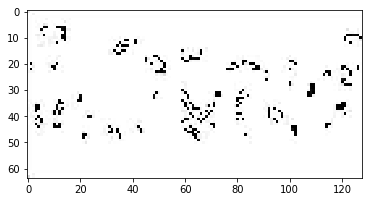

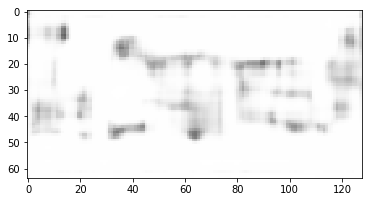

images/229.jpg


In [173]:
# Let's just view a few input images and output images from the autoencoder
#   This includes the decoder part of the autoencoder, so we'll still see an image

next_batch, next_filenames = next(test_images) # Use the test_images defined above
#next_batch = next(test_generator)
images = next_batch[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

recreated_pill = autoencoder.predict(x=images,batch_size=32)

plt.imshow(get_image(recreated_pill[0]))
plt.show()
print(next_filenames[0])



# Get a feel for the outputs

In [174]:
# Load a dataframe from the dictionary
import pandas as pd
df = pd.DataFrame.from_dict(image_encoding_dict, orient='index')

#df['filename'] = df.index
#df['image']= df['filename'].apply(lambda x: x.split('/')[-1])
#HOLY COW!  All of these are so close together. :-(  Can't differentiate one from another easily - Deeper network help?
#df.to_csv('96_images_32x64_AvgPool_4x8.csv')

df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
images/229.jpg,0.543482,0.266453,0.509105,0.545074,0.147486,0.503434,0.071164,0.221808,0.018240,0.093945,...,0.252018,0.275063,0.511650,0.390964,0.401899,0.462805,0.198203,0.290082,0.138443,0.229468
images/229_196.jpg,0.553301,0.272848,0.545469,0.569743,0.132234,0.481732,0.069944,0.238879,0.033842,0.100346,...,0.253239,0.310327,0.565219,0.414375,0.411720,0.492390,0.205647,0.293689,0.151890,0.229500
images/229_262.jpg,0.555806,0.244646,0.511240,0.537773,0.146571,0.512471,0.074270,0.223083,0.023009,0.110986,...,0.250998,0.258394,0.534717,0.392150,0.389245,0.511838,0.199464,0.302839,0.122728,0.239932
images/229_45.jpg,0.534408,0.262276,0.530359,0.437240,0.121258,0.509993,0.082858,0.232100,0.024247,0.119422,...,0.265513,0.272096,0.471661,0.368299,0.414804,0.460721,0.216711,0.296156,0.130596,0.234516
images/230.jpg,0.338270,0.198482,0.428972,0.235713,0.163554,0.386394,0.154222,0.316034,0.029617,0.147232,...,0.254661,0.225497,0.437451,0.286812,0.391907,0.409601,0.263627,0.257673,0.102074,0.235000
images/230_200.jpg,0.341321,0.223157,0.421262,0.261329,0.156719,0.352991,0.155425,0.354102,0.025384,0.160028,...,0.225751,0.208959,0.408790,0.227424,0.407826,0.384029,0.279153,0.275319,0.112153,0.230014
images/230_287.jpg,0.346577,0.198312,0.426773,0.226001,0.177260,0.437014,0.138077,0.342725,0.034662,0.143402,...,0.242785,0.203804,0.402671,0.200747,0.370811,0.412534,0.252075,0.296117,0.099045,0.230692
images/230_341.jpg,0.305025,0.206153,0.363564,0.262066,0.161849,0.348828,0.153444,0.333231,0.026767,0.149232,...,0.229023,0.188599,0.366821,0.246820,0.351359,0.369625,0.276648,0.272082,0.110824,0.227271
images/231.jpg,0.380833,0.245383,0.463484,0.342788,0.153028,0.432355,0.097601,0.323243,0.026651,0.145036,...,0.230312,0.252059,0.430829,0.301919,0.388621,0.444606,0.252683,0.263836,0.116327,0.219362
images/231_212.jpg,0.369167,0.246706,0.395776,0.254899,0.139354,0.462342,0.123810,0.328221,0.020533,0.143827,...,0.237530,0.254547,0.463518,0.248632,0.437226,0.439509,0.257850,0.259664,0.126813,0.253721


In [175]:
# Look at the simple statistics around the encodings
dfstat = df.describe()
dfstat

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,...,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.387530,0.239028,0.428393,0.345308,0.157701,0.414204,0.115266,0.302030,0.042928,0.132608,...,0.246809,0.222818,0.446182,0.292321,0.367321,0.415427,0.238784,0.282298,0.127600,0.213689
std,0.060040,0.046610,0.067571,0.099190,0.022960,0.059004,0.021446,0.033550,0.032009,0.022156,...,0.024531,0.034741,0.067075,0.065668,0.040142,0.066324,0.032752,0.022233,0.022287,0.019931
min,0.263737,0.133967,0.263387,0.174730,0.106657,0.292453,0.064329,0.221808,0.017774,0.074271,...,0.174433,0.149281,0.318335,0.150929,0.281149,0.246688,0.162924,0.236495,0.083572,0.166524
25%,0.349531,0.202060,0.373038,0.263726,0.139815,0.374863,0.099519,0.276707,0.025120,0.118763,...,0.228599,0.195777,0.401669,0.246415,0.331152,0.368192,0.226241,0.262416,0.112077,0.197891
50%,0.377116,0.239849,0.426442,0.342622,0.158353,0.407615,0.118779,0.305169,0.029998,0.136016,...,0.249678,0.221076,0.439637,0.301153,0.370891,0.412574,0.244467,0.282495,0.127010,0.215643
75%,0.418591,0.269731,0.480916,0.416621,0.172077,0.448128,0.128877,0.325433,0.038344,0.148316,...,0.265350,0.247684,0.499523,0.337797,0.401111,0.464736,0.260296,0.297768,0.143661,0.228129
max,0.555806,0.362895,0.566468,0.569743,0.216288,0.565619,0.170914,0.379423,0.140832,0.170530,...,0.301129,0.310327,0.572430,0.433728,0.460882,0.571529,0.292658,0.338313,0.176813,0.257427


In [176]:
# See how they all cluster
from sklearn.cluster import KMeans

number_of_clusters=24
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(df)
print(km.labels_)

[ 4  4  4  4 15  0  0  0  2 15  2 15  5  5  5  5  0 19  0  0 19  9  9  9
  1  1  1  1 22  3 22  3  8  8  8  8 19 18 18 18  2  2  2  2 23 23 10 23
 11 11 11 11  7  7  7  7 16 16 16 16 17 17 17 17 21  6 21  6 14 14 14 14
 18 18 18 18 20 20 20 20 10 10 10 10 17 17 17  2 12 12 12 12 13 13 13 13]


In [177]:
# Convert results to a dataframe - note that to get the index / filename, I had to include the first column
results = pd.DataFrame({
    'ignore': df[0],
    'category': km.labels_
})
results

,ignore,category
images/229.jpg,0.543482,4
images/229_196.jpg,0.553301,4
images/229_262.jpg,0.555806,4
images/229_45.jpg,0.534408,4
images/230.jpg,0.338270,15
images/230_200.jpg,0.341321,0
images/230_287.jpg,0.346577,0
images/230_341.jpg,0.305025,0
images/231.jpg,0.380833,2
images/231_212.jpg,0.369167,15


In [178]:
#show the distance between images
#  should be small distances between rotated images - ideally zero
from scipy.spatial.distance import squareform, pdist
distdf = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
distdf

,images/229.jpg,images/229_196.jpg,images/229_262.jpg,images/229_45.jpg,images/230.jpg,images/230_200.jpg,images/230_287.jpg,images/230_341.jpg,images/231.jpg,images/231_212.jpg,...,images/250_323.jpg,images/250_331.jpg,images/251.jpg,images/251_327.jpg,images/251_355.jpg,images/251_48.jpg,images/252.jpg,images/252_135.jpg,images/252_68.jpg,images/252_75.jpg
images/229.jpg,0.000000,0.326470,0.274947,0.274377,1.263010,1.390952,1.344566,1.466595,1.052687,1.187821,...,0.872675,1.045747,2.076613,1.831260,1.840172,2.002675,1.163785,1.226893,1.294516,1.104088
images/229_196.jpg,0.326470,0.000000,0.332537,0.417725,1.452711,1.578417,1.538356,1.672715,1.244011,1.379332,...,1.045331,1.247603,2.289065,2.035904,2.047620,2.207071,1.368770,1.435701,1.504584,1.304430
images/229_262.jpg,0.274947,0.332537,0.000000,0.351254,1.267270,1.407514,1.339323,1.486274,1.081438,1.202775,...,0.873452,1.066202,2.098591,1.851409,1.863715,2.020322,1.186527,1.252718,1.329256,1.134149
images/229_45.jpg,0.274377,0.417725,0.351254,0.000000,1.159982,1.294709,1.247732,1.371782,0.958144,1.103023,...,0.778094,0.953915,1.986797,1.737285,1.744454,1.908352,1.101509,1.153547,1.216998,1.032191
images/230.jpg,1.263010,1.452711,1.267270,1.159982,0.000000,0.312508,0.283750,0.359361,0.392987,0.351145,...,0.531426,0.394349,0.963255,0.742229,0.755431,0.879422,0.581310,0.519113,0.609082,0.544702
images/230_200.jpg,1.390952,1.578417,1.407514,1.294709,0.312508,0.000000,0.334151,0.275940,0.511494,0.437953,...,0.684447,0.560525,0.854302,0.647966,0.652711,0.772338,0.679387,0.576495,0.623243,0.596855
images/230_287.jpg,1.344566,1.538356,1.339323,1.247732,0.283750,0.334151,0.000000,0.382346,0.473099,0.410287,...,0.647149,0.464894,0.906979,0.697434,0.724286,0.834245,0.667997,0.584012,0.644858,0.623366
images/230_341.jpg,1.466595,1.672715,1.486274,1.371782,0.359361,0.275940,0.382346,0.000000,0.597820,0.513560,...,0.778367,0.610104,0.738214,0.570581,0.550087,0.672763,0.646098,0.527933,0.554132,0.596367
images/231.jpg,1.052687,1.244011,1.081438,0.958144,0.392987,0.511494,0.473099,0.597820,0.000000,0.361085,...,0.442314,0.379257,1.143413,0.907860,0.916702,1.063513,0.563695,0.543713,0.614469,0.493789
images/231_212.jpg,1.187821,1.379332,1.202775,1.103023,0.351145,0.437953,0.410287,0.513560,0.361085,0.000000,...,0.496006,0.383013,1.039210,0.802118,0.814473,0.965314,0.592030,0.531966,0.596415,0.504132


In [179]:
# Show the covariance between the columns - not useful since it's unscaled. :-(
#covdf = df.cov()*10000 #, columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
#covdf

In [180]:
# Show the correlation between the columns (which represent a global pool from the encoder convolutions)
#   Correlation appears high, likely could do some PCA, but seems like tuning the autoencoder should be able to do that
corrdf = df.corr() #, columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
corrdf

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,1.000000,0.473652,0.676874,0.691856,0.084910,0.606768,-0.402572,-0.776040,-0.078569,-0.509398,...,0.183842,0.613093,0.665324,0.715104,0.484191,0.656511,-0.467365,0.401565,0.231885,0.452222
1,0.473652,1.000000,0.672037,0.511307,0.388241,0.726772,0.039435,-0.393127,0.524711,-0.594070,...,0.128340,0.257955,0.658365,0.589050,0.298336,0.801005,-0.595467,0.435975,0.500766,0.519954
2,0.676874,0.672037,1.000000,0.669759,0.401575,0.732627,-0.304662,-0.725583,0.433518,-0.776793,...,0.068214,0.346952,0.750749,0.792927,0.248568,0.811986,-0.728212,0.537481,0.539195,0.518627
3,0.691856,0.511307,0.669759,1.000000,-0.013540,0.576528,-0.551486,-0.783258,0.204270,-0.757740,...,-0.191738,0.299762,0.725547,0.890006,0.009768,0.637305,-0.749092,0.215228,0.489913,0.309535
4,0.084910,0.388241,0.401575,-0.013540,1.000000,0.276233,0.210801,-0.042581,0.584638,-0.259250,...,0.289508,0.097757,0.236968,0.067315,0.233857,0.350201,-0.212607,0.617295,0.274361,0.333540
5,0.606768,0.726772,0.732627,0.576528,0.276233,1.000000,-0.215567,-0.520494,0.470837,-0.719579,...,0.014985,0.447900,0.723551,0.651191,0.352352,0.824693,-0.675019,0.449290,0.457407,0.663478
6,-0.402572,0.039435,-0.304662,-0.551486,0.210801,-0.215567,1.000000,0.570960,-0.032202,0.469589,...,0.296537,-0.173765,-0.233288,-0.472281,0.160068,-0.170509,0.439346,-0.083817,-0.281367,-0.000720
7,-0.776040,-0.393127,-0.725583,-0.783258,-0.042581,-0.520494,0.570960,1.000000,-0.033644,0.688103,...,0.014434,-0.257947,-0.656387,-0.799403,-0.086931,-0.573055,0.658664,-0.368199,-0.384447,-0.311791
8,-0.078569,0.524711,0.433518,0.204270,0.584638,0.470837,-0.032202,-0.033644,1.000000,-0.554620,...,-0.062215,-0.080699,0.314057,0.256228,-0.171552,0.419996,-0.578914,0.367818,0.622562,0.333870
9,-0.509398,-0.594070,-0.776793,-0.757740,-0.259250,-0.719579,0.469589,0.688103,-0.554620,1.000000,...,0.094885,-0.167571,-0.668046,-0.779305,0.026295,-0.698486,0.943146,-0.393251,-0.713983,-0.414857


# Annoy for nearest neighbor search

In [181]:
# Create Annoy database file

from annoy import AnnoyIndex

embedding_vector_size = 128

f = embedding_vector_size      # Length of item vector that will be indexed
t = AnnoyIndex(f)  

for i in range(len(image_encoding_dict)):
    t.add_item(i,image_encoding_dict[image_filename_dict[i]])
    
t.build(10) # 25 trees - need to explore what is a good setting here
t.save(model_name + '.ann') # Save the model



True

In [184]:
# Open Annoy database file get example

sample_item_index = 6
nn_count = 10 # count of nearest neighbors to find

u = AnnoyIndex(f)
u.load(model_name + '.ann') # super fast, will just mmap the file

nn = u.get_nns_by_item(sample_item_index, nn_count) # will find the 5 nearest neighbors

for i in nn:
    distance = u.get_distance(sample_item_index, i)
    print(str(i) + ' - ' + image_filename_dict[i] + ' : ' + str(distance))
    



6 - images/230_287.jpg : 0.0
4 - images/230.jpg : 0.08173618465662003
5 - images/230_200.jpg : 0.09855704009532928
17 - images/233_207.jpg : 0.10384377837181091
7 - images/230_341.jpg : 0.10474145412445068
16 - images/233.jpg : 0.11346492171287537
9 - images/231_212.jpg : 0.11510320752859116
19 - images/233_83.jpg : 0.11642961949110031
11 - images/231_80.jpg : 0.11717485636472702
87 - images/250_331.jpg : 0.11831595748662949


In [49]:
# For confusion matrix, you need two items, y_test and y_pred
#     y_test is the known categorical values of the test set 
#     y_pred is the predicted categorical values of the test set 

# To get y_test we'll use the validation_generator, but let's grab all images
#test_generator.batch_size = 751

nb_batches_to_capture = 1 # batches * batch_size should be less than total number of items available, else repeats will happen

y_true = []
y_pred = []

for index in range(nb_batches_to_capture):
    next_batch = next(test_generator)
    #images = next_batch[0]
    #print(images[0])
    categories = next_batch[1]
    #print(categories[0])
    #print(len(categories))
    # To get y_pred, we actually need to predict the categories of the all_images set
    #predicted_categories= model.predict_classes(x=images,batch_size=batch_size)
    #print(len(predicted_categories))
    #if len(categories) == len(predicted_categories):
    #    y_true.extend(categories)
    #    y_pred.extend(predicted_categories)
    #else:
    #    print("Mismatched actual and predicted - ignoring batch")
    
print(len(y_true))
print(len(y_pred))

NameError: name 'test_generator' is not defined

In [191]:
# Create methods for determining closest image
def retrieve_closest_elements(test_code, test_label, learned_codes):
    distances = []
    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    return sorted_distances, sorted_labels, sorted_indexes


def compute_average_precision_score(test_codes, test_labels, learned_codes, n_samples):
    out_labels = []
    out_distances = []
    retrieved_elements_indexes = []
    for i in range(len(test_codes)):
        sorted_distances, sorted_labels, sorted_indexes = retrieve_closest_elements(test_codes[i], test_labels[i], learned_codes)
        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])
        retrieved_elements_indexes.append(sorted_indexes[:n_samples])

    out_labels = np.array(out_labels)
    out_labels_file_name = 'computed_data/out_labels_{}'.format(n_samples)
    np.save(out_labels_file_name, out_labels)

    out_distances_file_name = 'computed_data/out_distances_{}'.format(n_samples)
    out_distances = np.array(out_distances)
    np.save(out_distances_file_name, out_distances)
    score = label_ranking_average_precision_score(out_labels, out_distances)
    scores.append(score)
    return score


def retrieve_closest_images(test_element, test_label, n_samples=10):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])

    test_code = encoder.predict(np.array([test_element]))
    test_code = test_code.reshape(test_code.shape[1] * test_code.shape[2] * test_code.shape[3])

    distances = []

    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    kept_indexes = sorted_indexes[:n_samples]

    score = label_ranking_average_precision_score(np.array([sorted_labels[:n_samples]]), np.array([sorted_distances[:n_samples]]))

    print("Average precision ranking score for tested element is {}".format(score))

    original_image = x_test[0]
    cv2.imshow('original_image', original_image)
    retrieved_images = x_train[int(kept_indexes[0]), :]
    for i in range(1, n_samples):
        retrieved_images = np.hstack((retrieved_images, x_train[int(kept_indexes[i]), :]))
    cv2.imshow('Results', retrieved_images)
    #cv2.waitKey(0)

    cv2.imwrite('test_results/original_image.jpg', 255 * cv2.resize(original_image, (0,0), fx=3, fy=3))
    cv2.imwrite('test_results/retrieved_results.jpg', 255 * cv2.resize(retrieved_images, (0,0), fx=2, fy=2))



In [192]:
# Create methods to test the model
def test_model(n_test_samples, n_train_samples):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0], learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])
    test_codes = encoder.predict(x_test)
    test_codes = test_codes.reshape(test_codes.shape[0], test_codes.shape[1] * test_codes.shape[2] * test_codes.shape[3])
    indexes = np.arange(len(y_test))
    np.random.shuffle(indexes)
    indexes = indexes[:n_test_samples]

    print('Start computing score for {} train samples'.format(n_train_samples))
    t1 = time.time()
    score = compute_average_precision_score(test_codes[indexes], y_test[indexes], learned_codes, n_train_samples)
    t2 = time.time()
    print('Score computed in: ', t2-t1)
    print('Model score:', score)


def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 1))
    test_img = x_test_noisy[0]
    resized_test_img = cv2.resize(test_img, (280, 280))
    #cv2.imshow('input', resized_test_img)
    #cv2.waitKey(0)
    output = denoised_images[0]
    resized_output = cv2.resize(output, (280, 280))
    #cv2.imshow('output', resized_output)
    #cv2.waitKey(0)
    cv2.imwrite('test_results/noisy_image.jpg', 255 * resized_test_img)
    cv2.imwrite('test_results/denoised_image.jpg', 255 * resized_output)


In [ ]:
# Save model
np.save('computed_data/scores', np.array(scores))

In [ ]:
# To retrieve closest image
retrieve_closest_images(x_test[0], y_test[0])


In [ ]:

# To plot a denoised image
plot_denoised_images()

In [ ]:
print('hello')